# Chapter 4 Code

Let's start with some imports.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from quantecon import MarkovChain

## Introduction to Dynamics

Here's the code that generated figure 4.1.

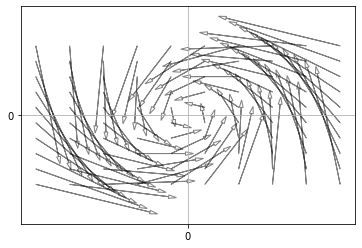

In [2]:
def draw_arrow(x, y, xp, yp, ax):
    """
    Draw an arrow from (x, y) to (xp, yp).
    """
    v1, v2 = xp - x, yp - y
    eps = 1.0
    nrm = np.sqrt(v1**2 + v2**2)
    scale = 1.0
    ax.arrow(x, y, scale * v1, scale * v2,
            antialiased=True, 
            alpha=0.5,
            head_length=0.025*(xmax - xmin), 
            head_width=0.012*(xmax - xmin),
            fill=False)

xmin, xmax = -10.0, 10.0
ymin, ymax = -5.0,  5.0

A1 = np.asarray([[0.55, -0.6],
                 [0.5, 0.4]])

def f(x, y): 
    return  A1 @ (x, y)

xgrid = np.linspace(xmin * 0.95, xmax * 0.95, 10)
ygrid = np.linspace(ymin * 0.95, ymax * 0.95, 10)

fig, ax = plt.subplots()

#ax.set_xlim(xmin, xmax)
#ax.set_ylim(ymin, ymax)

ax.set_xticks((0,))
ax.set_yticks((0,))
ax.grid()

for x in xgrid:
    for y in ygrid:
        xp, yp = f(x, y)
        draw_arrow(x, y, xp, yp, ax)

#plt.savefig("sdsdiagram.pdf")  # Uncomment to save figure
plt.show()

And here's the code that generated figure 4.2.

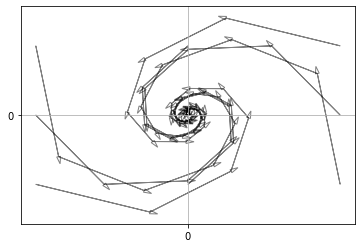

In [3]:

def draw_trajectory(x, y, ax, n=10):
    """
    Draw the trajectory of length n starting from (x, y).
    """
    for i in range(n):
        x_new, y_new = f(x, y)
        draw_arrow(x, y, x_new, y_new, ax)
        x, y = x_new, y_new
        
xgrid = np.linspace(xmin * 0.95, xmax * 0.95, 3)
ygrid = np.linspace(ymin * 0.95, ymax * 0.95, 3)

fig, ax = plt.subplots()

#ax.set_xlim(xmin, xmax)
#ax.set_ylim(ymin, ymax)

ax.set_xticks((0,))
ax.set_yticks((0,))
ax.grid()

for x in xgrid:
    for y in ygrid:
        draw_trajectory(x, y, ax)

#plt.savefig("sdsstable.pdf")  # Uncomment to save figure
plt.show()

## Chaotic Dynamics

Just for fun, here's a little class that allows us to simulate trajectories
from a specified dynamical system:

In [4]:
class DS:

    def __init__(self, h=None, x=None):
        """Parameters: h is a function and x is an 
        element of S representing the current state."""
        self.h, self.x = h, x

    def update(self):
        "Update the state of the system by applying h."
        self.x = self.h(self.x)

    def trajectory(self, n):
        """Generate a trajectory of length n, starting 
        at the current state."""
        traj = []
        for i in range(n):
            traj.append(self.x)
            self.update()
        return traj

As in the textbook, let's plot a trajectory starting from 0.11.

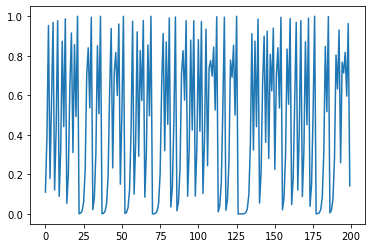

In [5]:

q = DS(h=lambda x: 4 * x * (1 - x), x=0.11)
t = q.trajectory(200)

fig, ax = plt.subplots()
ax.plot(t)

plt.show()


Now let's generate a histograms from a long trajectory, to address exercise
4.16.

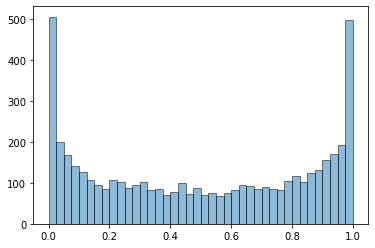

In [6]:
q.x = 0.11
t = q.trajectory(5000)

fig, ax = plt.subplots()
ax.hist(t, bins=40, alpha=0.5, edgecolor='k')

plt.show()


If you experiment with different initial conditions you will find that, for
all most all choices, the histogram looks the same.

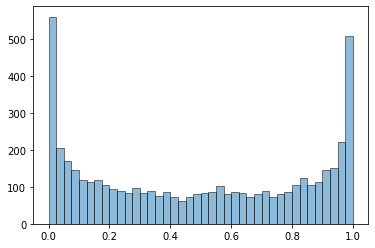

In [7]:
q.x = 0.65
t = q.trajectory(5000)

fig, ax = plt.subplots()
ax.hist(t, bins=40, alpha=0.5, edgecolor='k')

plt.show()


What we have learned is that, although the trajectories seem very random, when
we take a statistical perspective we can make predictions.

In particular, we can say what will happen "one average, in the long run."


Here's the set of maps.

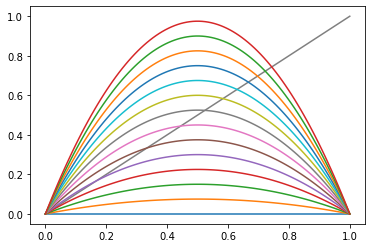

In [8]:
xgrid = np.linspace(0, 1, 100)

h = lambda x, r: r * x * (1 - x)

fig, ax = plt.subplots()

ax.plot(xgrid, xgrid, '-', color='grey')

r = 0
step = 0.3

while r <= 4:
    y = [h(x, r) for x in xgrid]
    ax.plot(xgrid, y)
    r = r + step

plt.show()


Here's the bifurcation diagram.

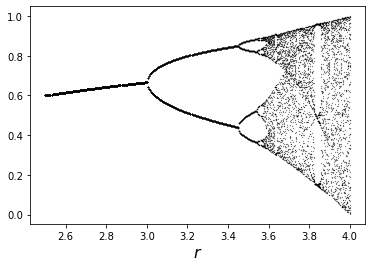

In [9]:
q = DS(h=None, x=0.1)

fig, ax = plt.subplots()

r = 2.5
while r < 4:
    q.h = lambda x: r * x * (1 - x)
    t = q.trajectory(1000)[950:]
    ax.plot([r] * len(t), t, 'k.', ms=0.4)
    r = r + 0.005

ax.set_xlabel(r'$r$', fontsize=16)
plt.show()


## Markov Chains


Our first task is to simulate time series from Hamilton's Markov chain

In [10]:
pH = ((0.971, 0.029, 0.000),       # Hamilton's kernel
      (0.145, 0.778, 0.077),
      (0.000, 0.508, 0.492))

pH = np.array(pH)                  # Convert to numpy array

S = np.array((0, 1, 2))

We'll borrow this code from Chapter 2.

In [11]:
@jit
def tau(z, S, phi):
    i = np.searchsorted(np.cumsum(phi), z)
    return S[i]

(We have targeted the function for JIT compilation via `@jit` because we need
fast execution below.)

As discussed in that chapter, if we create a function `tau` using this code and feed it uniform draws on $(0,1]$, we get draws from `S` distributed according to `phi`.

Here's some code to generate a trajectory starting at $x \in S$, using
stochastic kernel $p$.

In [12]:
def trajectory(x, p, S, n=100):

        X = np.empty(n, dtype=int)
        X[0] = x
        for t in range(n-1):
            W = np.random.rand()
            X[t+1] = tau(W, S, p[X[t], :])
        return X

Let's plot a trajectory.

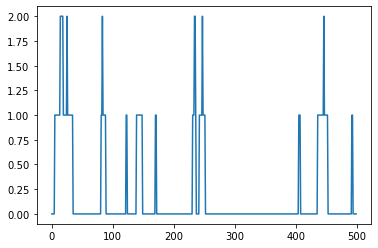

In [13]:
fig, ax = plt.subplots()

X = trajectory(0, pH, S, n=500)

ax.plot(X)
plt.show()


Another option is to use existing code from QuantEcon.  This code is
JIT-compiled and very fast.

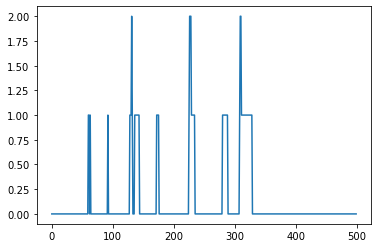

In [14]:
mc = MarkovChain(pH, state_values=S)
X = mc.simulate(init=0, ts_length=500)

fig, ax = plt.subplots()
ax.plot(X)
plt.show()

Here's a solution to exercises 4.23.

In [15]:
@jit
def compute_marginal(n=100_000, T=10):
    X_vals = np.empty(n)

    for i in range(n):
        X = 2                   # start in state SR
        for t in range(T):
            W = np.random.rand()
            X = tau(W, S, pH[X, :])
        X_vals[i] = X
    return np.mean(X_vals == 0)

compute_marginal()

0.59744

The answer is close to 0.6, as expected.


Here's a solution to exercise 4.24.

In [16]:
@jit
def compute_marginal_2(n=100_000, T=10):
    counter = 0

    for i in range(n):
        X = 2                   # start in state SR
        for t in range(T):
            W = np.random.rand()
            X = tau(W, S, pH[X, :])
        if X == 0:
            counter += 1

    return counter / n

compute_marginal_2()

0.5999

Here's a solution to exercise 4.29.

In [17]:
T = 5
psi = (1, 0, 0)         # start in NG
h = (1000, 0, -1000)    # profits

for t in range(T):
    psi = psi @ pH

print(psi @ h)

885.347632676323


Now let's see what happens when we start in severe recession.

In [18]:
psi = (0, 0, 1) 

for t in range(T):
    psi = psi @ pH

print(psi @ h)

217.74304876607997


Profits are much lower because the Markov chain is relatively persistent,
implying that starting in recession increases the probability of recession at
date $t=5$.


Here's a solution to exercise 4.30.

In [19]:
T = 1000

for i in (0, 1, 2):
    psi = np.zeros(3)
    psi[i] = 1
    for t in range(T):
        psi = psi @ pH
    print(f"Profits in state {i} at date {T} equals {psi @ h}")

Profits in state 0 at date 1000 equals 788.1599999999967
Profits in state 1 at date 1000 equals 788.1599999999974
Profits in state 2 at date 1000 equals 788.1599999999972


Notice that profits are almost invariant with respect to the initial
condition.

This is due to inherent stability of the kernel, which implies that initial
conditions become irrelevant after sufficient time has elapsed.

Here's a solution to exercise 4.31.

In [20]:
T = 5
psi = (0.2, 0.2, 0.6) 

for t in range(T):
    psi = psi @ pH

print(psi @ h)

385.45189053788556


Here's a solution to exercise 4.32.

In [21]:
def path_prob(p, psi, X):   # X gives a time path
    prob = psi[X[0]]
    for t in range(len(X)-1):
        prob = prob * p[X[t], X[t+1]]
    return prob

psi = np.array((0.2, 0.2, 0.6))
prob = path_prob(pH, psi, (0, 1, 0))

print(prob)

0.0008410000000000001


Here's a solution to exercise 4.33.

In [22]:
counter = 0
recession_states = 1, 2
for x0 in recession_states:
    for x1 in recession_states:
        for x2 in recession_states:
            path = x0, x1, x2
            counter += path_prob(pH, psi, path)

print(counter)

0.704242


Here's a solution to exercise 4.34.

In [23]:
counter = 0
m  = 10_000
mc = MarkovChain(pH)

for i in range(m):
    x0 = tau(np.random.rand(), S, psi)
    X = mc.simulate(init=x0, ts_length=3)
    if 0 not in X:
        counter += 1

print(counter / m)

0.7085

Next we turn to exercise 4.36.

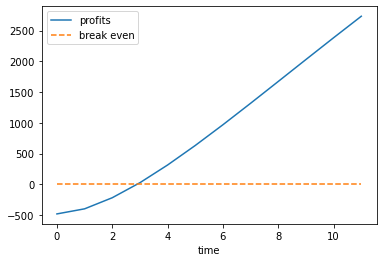

In [24]:
max_T = 12
T_vals = range(max_T)
profits = []
r = 0.05
rho = 1 / (1+r)

psi = (0.2, 0.2, 0.6) 
h = (1000, 0, -1000)    
current_profits = np.inner(psi, h)
discount = rho
Q = np.identity(3)

for t in T_vals:
    Q = Q @ pH
    discount = discount * rho
    current_profits += discount * np.inner(psi, Q @ h)
    profits.append(current_profits)

fig, ax = plt.subplots()
ax.plot(profits, label='profits')
ax.plot(np.zeros(max_T), '--', label='break even')
ax.set_xlabel('time')
ax.legend()

plt.show()


Here's figure 4.11.

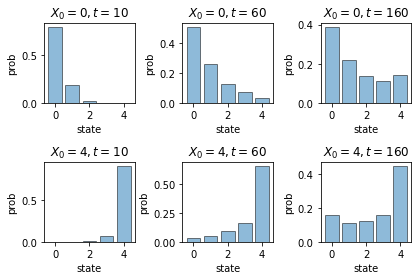

In [25]:
p_Q = ((0.97 , 0.03 , 0.00 , 0.00 , 0.00),
       (0.05 , 0.92 , 0.03 , 0.00 , 0.00),
       (0.00 , 0.04 , 0.92 , 0.04 , 0.00),
       (0.00 , 0.00 , 0.04 , 0.94 , 0.02),
       (0.00 , 0.00 , 0.00 , 0.01 , 0.99))

p_Q = np.array(p_Q)
states = 0, 1, 2, 3, 4
dates = 10, 60, 160
initial_states = 0, 4

rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols)

for row, init in enumerate(initial_states):
    psi = np.zeros(5)
    psi[init] = 1
    for col, d in enumerate(dates):
        ax = axes[row, col]
        ax.bar(states, 
                psi @ np.linalg.matrix_power(p_Q, d), 
                alpha=0.5,
                edgecolor='k')
        ax.set_title(f"$X_0 = {init}, t = {d}$")
        ax.set_ylabel("prob")
        ax.set_xlabel("state")

plt.tight_layout()

#plt.savefig("dds2.pdf")
plt.show()

And here's figure 4.12.

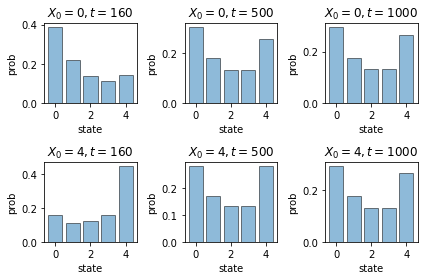

In [26]:
dates = 160, 500, 1000

fig, axes = plt.subplots(rows, cols)

for row, init in enumerate(initial_states):
    psi = np.zeros(5)
    psi[init] = 1
    for col, d in enumerate(dates):
        ax = axes[row, col]
        ax.bar(states, 
                psi @ np.linalg.matrix_power(p_Q, d), 
                alpha=0.5,
                edgecolor='k')
        ax.set_title(f"$X_0 = {init}, t = {d}$")
        ax.set_ylabel("prob")
        ax.set_xlabel("state")

plt.tight_layout()

#plt.savefig("dds3.pdf")
plt.show()

Next we turn to exercise 4.42.

First here's a function to compute the stationary distribution, assuming it is
unique.

In [27]:
from numpy.linalg import solve

def compute_stationary(p):
    N = p.shape[0]
    I = np.identity(N)
    O = np.ones((N, N))
    A = I - p + O
    return solve(A.T, np.ones((N, 1))).flatten()


Now let's apply it to `p_Q`.

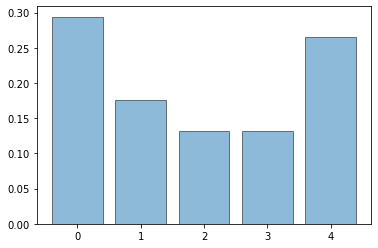

In [28]:
psi_star = compute_stationary(p_Q)

fig, ax = plt.subplots()
ax.bar(states, psi_star, alpha=0.5, edgecolor='k')

plt.show()

As expected, the distribution is very similar to the time 1,000 distribution
we obtained above by shifting forward in time.


Now let's look at exercise 4.43.

In [29]:
psi_star = compute_stationary(pH)  
print(np.inner(psi_star, h))

788.1600000000004


If we compute profits at $t=1000$, starting from a range of initial
conditions, we get very similar results.

In [30]:
pT = np.linalg.matrix_power(pH, 1000)
psi_vecs = (1, 0, 0), (0, 1, 0), (0, 0, 1)

for psi in psi_vecs:
    print(np.inner(psi, pT @ h))

788.1599999999779
788.1599999999786
788.1599999999784


This is not surprising, since `p_H` is globally stable.


Here's the solution to exercise 4.57, which computes mean return time.

I'll use JIT compilation to make the code fast.

In [31]:
@jit
def compute_return_time(x, p, max_iter=100_000):
    X = x
    t = 0
    while t < max_iter:
        W = np.random.rand()
        X = tau(W, S, pH[X, :])
        t += 1
        if X == x:
            return t

@jit
def compute_mean_return_time(x, p, n=100_000):
    counter = 0
    for i in range(n):
        counter += compute_return_time(x, p)
    return counter / n


[compute_mean_return_time(i, pH) for i in range(3)]


[1.22771, 6.14, 40.60528]

For comparison:

In [32]:
psi_star = compute_stationary(pH)
1/ psi_star


array([ 1.23031496,  6.1515748 , 40.58441558])

As predicted by the theory, the values are approximately equal.


Now let's turn to the inventory model.

In [33]:
def b(d):
    " Returns probability that demand = d."
    return (d >= 0) * (1/2)**(d + 1)

def h(x, q, Q):
    return  x + (Q - x) * (x <= q)

def build_p(q=2, Q=5): 
    p = np.empty((Q+1, Q+1))
    for x in range(Q+1):
        for y in range(Q+1):
            if y == 0:
                p[x,y] = (1/2)**h(x, q, Q)    # prob D >= h(x, q)
            else:
                p[x,y] = b(h(x, q, Q) - y)    # prob h(x, q) - D = y

    return p


Let's verify that the stationary distribution at $q=2$ and $Q=5$ matches the
one shown in the text.

In [34]:
p = build_p()
compute_stationary(p)



array([0.0625, 0.0625, 0.125 , 0.25  , 0.25  , 0.25  ])

Yep, looks good.

Now let's check that the optimal policy agrees with $q=7$, as claimed in the text.

In [35]:
Q = 20   # inventory upper bound
C = 0.1  # cost of restocking

# profit given state x, demand d, policy q
def profit(x, d, q):
    stock = h(x, q, Q)
    revenue = stock if stock < d else d
    cost = C * (x <= q)
    return revenue - cost

# expected profit given x and policy q
def g(x, q):
    counter = 0
    for d in range(1000):
        counter += profit(x, d, q) * b(d)
    return counter

def profit_at_stationary(q):
    p = build_p(q=q, Q=Q)
    stationary = compute_stationary(p)
    counter = 0
    for x in range(Q+1):
        counter += g(x, q) * stationary[x]
    return counter
     
def compute_optimal_policy():
    running_max = -np.inf
    for q in range(Q+1):
        counter = profit_at_stationary(q)
        if counter > running_max:
            running_max = counter
            argmax = q
    return(argmax)

compute_optimal_policy()

7

Here's a solution for exercise 4.61.  From preceding calculations we have
the stationary probability assigned to normal growth:

In [36]:
psi_star = compute_stationary(pH)  
psi_star[0]

0.8128000000000003

The fraction of the time a long path spends in this state can be calculated as
follows.

In [37]:
T = 1_000_000
mc = MarkovChain(pH)
X = mc.simulate(init=0, ts_length=T)
np.mean(X == 0)

0.810454

As expected given the LLN results for stable Markov chains, the two numbers are approximately equal.


Finally, let's look at the expected profits question in exercise 4.63.

Previously we calculated steady state profits via

In [38]:
h = (1000, 0, -1000)
psi_star = compute_stationary(pH)  
print(np.inner(psi_star, h))

788.1600000000004


To check that we get approximately the same results when simulating a long
time series, we can calculate as follows.

In [39]:
y = [h[x] for x in X]
np.mean(y)

785.87